In [1]:
import os
import sys
# print(sys.path)
module_path = os.path.abspath(os.path.join('.'))
# print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
# print(sys.path)

## Initiate RAY

In [2]:
from ray.rllib.algorithms.a3c import A3CConfig
from ray import tune, air
import ray
from env.environment import MalariaEnvironment

In [3]:
ray.init(ignore_reinit_error=True, num_cpus=1,local_mode=True)
# ray.init()

2023-07-19 14:49:14,800	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.8
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8265


## Prepare the Environment

In [4]:
from ray.tune.registry import register_env

def env_creator(env_config):
    return MalariaEnvironment()  # return an env instance

register_env("MalariaEnvironment", env_creator)
env = MalariaEnvironment()

config = A3CConfig()

# config = config.training(lr=0.01) #.rollouts(num_rollout_workers=1)
# config = config.framework(framework='tf2')

# Set the config object's env.
config = config.environment(env="MalariaEnvironment")

In [13]:
from scipy.stats import linregress, sem

In [14]:
def measure_random_performance_for_env(env, episodes=1000, verbose=False):
    import numpy as np
    # Reset the env.
    env.reset()

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []

    # Enter while loop (to step through the episode).
    while num_episodes < episodes:
        # Produce a random action.
        action = env.action_space.sample()

        # Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, _ = env.step(action)
        episode_reward += reward

        # Check, whether the episde is done, if yes, reset and increase episode counter.
        if done:
            if verbose:
                print(f"Episode done - accumulated reward={episode_reward}")
            elif num_episodes % 100 == 0:
                print(f" {num_episodes} ", end="")
            elif num_episodes % 10 == 0:
                print(".", end="")
            num_episodes += 1
            env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0

    # Print out and return mean episode reward (and standard error of the mean).
    env_mean_random_reward = np.mean(episode_rewards)

    print(f"\n\nMean episode reward when acting randomly: {env_mean_random_reward:.2f}+/-{sem(episode_rewards):.2f}")

    return env_mean_random_reward, sem(episode_rewards)

In [ ]:
env_mean_random_reward, _ = measure_random_performance_for_env(env, episodes=100)

ACTION OrderedDict([('IRS', array([0.84481716], dtype=float32)), ('ITNS', array([0.22412187], dtype=float32))])
Setting IRS to 0.8448171615600586
Setting ITNS to 0.22412186861038208


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...

/home/mbwie001/ms/MSC_EMOD
Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Contr

## Run Tune Config

In [16]:
from ray.rllib.algorithms.a3c import A3CConfig
from ray import tune, air
import ray
import json
from env.environment import MalariaEnvironment
from ray.tune.logger import pretty_print
ray.init(ignore_reinit_error=True, num_cpus=1, local_mode=True)

# Parallel environments
from ray.tune.registry import register_env

def env_creator(env_config):
    return MalariaEnvironment()  # return an env instance

register_env("MalariaEnvironment", env_creator)
env = MalariaEnvironment()

config = A3CConfig()
# Print out some default values.
# print(config.sample_async)  
# Update the config object.
config = config.training(lr=0.01)
# config = config.rollouts(num_rollout_workers=1)
config = config.framework()

# Set the config object's env.
config = config.environment(env="MalariaEnvironment") 
# Use to_dict() to get the old-style python config dict
# when running with tune.

pretty_print(config.to_dict())


algo = config.build()  
# for i in range(10):
#     # print(f"Iteration Count: {i}")
#     training_results = algo.train()

# print(pretty_print(training_results))

# algo.train() 
# evaluation_duration
# metrics_episode_collection_timeout_s
# tune.Tuner(  
#     "A3C",
#     param_space=config.to_dict(),
#      run_config=air.RunConfig(local_dir="./agents/ray/results", name="test_experimen2t")
# ).fit()


2023-07-20 04:35:35,896	INFO worker.py:1370 -- Calling ray.init() again after it has already been called.
:actor_name:RolloutWorker


:actor_name:RolloutWorker
ACTION OrderedDict([('IRS', array([0.516175], dtype=float32)), ('ITNS', array([0.2633365], dtype=float32))])
Setting IRS to 0.5161749720573425
Setting ITNS to 0.26333650946617126


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...

/home/mbwie001/ms/MSC_EMOD
Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradicat

:actor_name:RolloutWorker
ACTION OrderedDict([('IRS', array([0.28976154], dtype=float32)), ('ITNS', array([0.02064], dtype=float32))])
Setting IRS to 0.2897615432739258
Setting ITNS to 0.020639995113015175


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...

/home/mbwie001/ms/MSC_EMOD
ACTION {'IRS': array([0.6208955], dtype=float32), 'ITNS': array([0.6297295], dtype=float32)}
Setting IRS to 0.620895504951477
Setting ITNS to 0.6297295093536377


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...



:actor_name:RolloutWorker


/home/mbwie001/ms/MSC_EMOD
Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign fil

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

ACTION {'IRS': array([0.29478586], dtype=float32), 'ITNS': array([0.7676967], dtype=float32)}
Setting IRS to 0.29478585720062256
Setting ITNS to 0.7676966786384583


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...

/home/mbwie001/ms/MSC_EMOD


2023-07-20 04:37:03,445	INFO trainable.py:172 -- Trainable.setup took 87.488 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-07-20 04:37:03,448	WARNING util.py:66 -- Install gputil for GPU system monitoring.


Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

 0 Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: ca

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

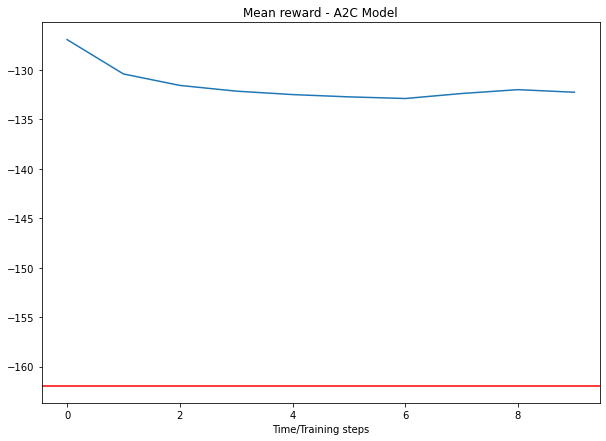

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

In [18]:
# Train for n more iterations (timesteps) and collect n-arm rewards.
import matplotlib.pyplot as plt
import numpy as np
rewards = []
for i in range(10):
    # Run a single timestep in the environment and update
    # the model immediately on the received reward.
    result = algo.train()
    # Extract reward from results.
    #rewards.extend(result["hist_stats"]["episode_reward"]
    rewards.append(result["episode_reward_mean"])
    if i % 50 == 0:
        print(f" {i} ", end="")
    elif i % 10 == 0:
        print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
start_at = 0
smoothing_win = 200
x = list(range(start_at, len(rewards)))
y = [np.nanmean(rewards[max(i - smoothing_win, 0):i + 1]) for i in range(start_at, len(rewards))]
plt.plot(x, y)
plt.title("Mean reward - A2C Model")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=env_mean_random_reward, color="r", linestyle="-")

plt.show()

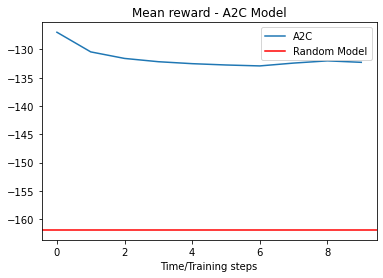

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

In [27]:
%matplotlib inline
plt.plot(x, y, label='A2C')
plt.title("Mean reward - A2C Model")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=env_mean_random_reward, color="r", linestyle="-", label='Random Model')
plt.legend()
plt.show()

In [5]:
!pwd

/home/mbwie001/ms/MSC_EMOD


In [ ]:
tune.run("A3C", config=config.rollouts(num_rollout_workers=1))

2023-06-07 12:26:04,041	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-06-07 12:26:04,046	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-06-07 12:26:04,494	WARNING worker.py:837 -- `ray.get_gpu_ids()` will always return the empty list when called from the driver. This is because Ray does not manage GPU allocations to the driver process.
:task_name:bundle_reservation_check_func


:task_name:bundle_reservation_check_func


:actor_name:A3C
2023-06-07 12:26:04,787	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-06-07 12:26:04,823	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


:actor_name:A3C


:actor_name:RolloutWorker
2023-06-07 12:26:05,138	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-06-07 12:26:05,146	WARNING env.py:159 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


:actor_name:RolloutWorker
ACTION OrderedDict([('IRS', array([0.81606364], dtype=float32)), ('ITNS', array([0.4142474], dtype=float32))])
Setting IRS to 0.816063642501831
Setting ITNS to 0.41424739360809326


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...

/home/mbwie001/ray_results/A3C/A3C_MalariaEnvironment_52880_00000_0_2023-06-07_12-26-04
Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] 

2023-06-07 12:26:38,987	INFO trainable.py:172 -- Trainable.setup took 34.177 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-07 12:26:38,993	WARNING util.py:66 -- Install gputil for GPU system monitoring.
:actor_name:A3C


:actor_name:A3C


2023-06-07 12:26:44,954	WARNING agent_collector.py:155 -- Provided tensor
[-1.1622524  0.3783719]
 does not match space of view requirements actions.
Provided tensor has shape (2,) and view requirement has shape shape None.Make sure dimensions match to resolve this warning.


Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [E] [Eradication] 

JsonTypeConfigurationException: 
Exception in utils/Configuration.cpp at 630 in GET_CONFIG_STRING.
While trying to parse json d

2023-06-07 12:28:35,990	WARNING util.py:244 -- The `start_trial` operation took 151.475 s, which may be a performance bottleneck.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
00:00:00 [0] [E] [Eradication] 

	Default -> INFO
	Eradication -> INFO
JsonTypeConfigurationException: 
Exception in utils/Configuration.cpp at 630 in GET_CONFIG_STRING.
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
While trying to parse json data for param/key >>> Maternal_Antibodies_Type <<< in otherwise valid json segment... 
{
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:

In [31]:
algo.train()

ACTION {'IRS': array([0.48402694], dtype=float32), 'ITNS': array([1.], dtype=float32)}
Setting IRS to 0.4840269386768341
Setting ITNS to 1.0


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...

ACTION {'IRS': array([0.14114097], dtype=float32), 'ITNS': array([0.], dtype=float32)}
Setting IRS to 0.14114096760749817
Setting ITNS to 0.0


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...

/home/mbwie001/ms/MSC_EMOD
/home/mbwie001/ms/MSC_EMOD
Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-p

2023-06-05 16:32:57,078	ERROR actor.py:1172 -- Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1045, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 782, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 823, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
  File "/home/mbwie001/.local/lib/python3.8/site-packages/ray/_private/function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/home/mbwie001/.local/lib/python3.8/site-packages/ray/util/tracing/tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "/home/mbwie001/.local/lib/python3.8/site-packages/ray/rllib/u

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

KeyboardInterrupt: 

Exception ignored in: 'ray._raylet.task_execution_handler'
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/contextlib.py", line 238, in helper
    @wraps(func)
KeyboardInterrupt: 


/home/mbwie001/ms/MSC_EMOD


KeyboardInterrupt: 

Exception ignored in: 'ray._raylet.task_execution_handler'
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/contextlib.py", line 238, in helper
    @wraps(func)
KeyboardInterrupt: 


Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

KeyboardInterrupt: 

Exception ignored in: 'ray._raylet.task_execution_handler'
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/contextlib.py", line 113, in __enter__
    return next(self.gen)
  File "/home/mbwie001/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 64, in disable_client_hook
    val = _disable_client_hook()
  File "/home/mbwie001/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 44, in _disable_client_hook
    out = _get_client_hook_status_on_thread()
  File "/home/mbwie001/.local/lib/python3.8/site-packages/ray/_private/client_mode_hook.py", line 32, in _get_client_hook_status_on_thread
    if not hasattr(_client_hook_status_on_thread, "status"):
KeyboardInterrupt: 


/home/mbwie001/ms/MSC_EMOD


KeyboardInterrupt: 

Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name identified as: campa

## Train Manually

In [29]:
algo = config.build()  
for i in range(1):
    print(f"Iteration Count: {i}")
    algo.train()

:actor_name:RolloutWorker
ACTION OrderedDict([('IRS', array([0.90205145], dtype=float32)), ('ITNS', array([0.5838243], dtype=float32))])
Setting IRS to 0.9020514488220215
Setting ITNS to 0.5838242769241333


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...



:actor_name:RolloutWorker


/home/mbwie001/ms/MSC_EMOD
Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign fil

:actor_name:RolloutWorker


/home/mbwie001/ms/MSC_EMOD
ACTION {'IRS': array([1.], dtype=float32), 'ITNS': array([1.], dtype=float32)}
Setting IRS to 1.0
Setting ITNS to 1.0


*** WRITING TO CAMPAIGNS FILE ***
*** SUCCESSFULLY CHANGED CAMPAIGNS FILE*** 


Action is setTrue

Starting Simulation...

/home/mbwie001/ms/MSC_EMOD
Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller

2023-06-05 16:06:56,992	INFO trainable.py:172 -- Trainable.setup took 20.079 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-05 16:06:56,996	WARNING util.py:66 -- Install gputil for GPU system monitoring.


Iteration Count: 0
Intellectual Ventures(R)/EMOD Disease Transmission Kernel 2.20.17.0
Built on Apr  9 2019 by idm_bamboo_user from master(2d8a9f2) checked in on 2019-04-05 15:49:43 -0700
Supports sim_types: GENERIC, VECTOR, MALARIA, AIRBORNE, TBHIV, STI, HIV, PY, TYPHOID, ENVIRONMENTAL.

Using config file: config.json
Using input path: .
Using output path: output
Using dll path: 
Python not initialized because --python-script-path (-P) not set.
Initializing environment...
Log-levels:
	Default -> INFO
	Eradication -> INFO
00:00:00 [0] [I] [Eradication] Loaded Configuration...
00:00:00 [0] [I] [Eradication] 195 parameters found.
00:00:00 [0] [I] [Eradication] Initializing Controller...
00:00:00 [0] [I] [Controller] DefaultController::execute_internal()...
00:00:00 [0] [I] [RandomNumberGeneratorFactory] Using USE_PSEUDO_DES random number generator.
00:00:00 [0] [I] [Controller] DefaultController::execute_internal() populate simulation...
00:00:00 [0] [I] [Simulation] Campaign file name i